In [1]:
#import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 18,8
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import seaborn as sns

In [2]:
dateparser = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
dataset = pd.read_csv('C:/Faculta anul 3 sem 2/Licenta/DJIA/WBA.csv', sep=',', index_col = 'Date', parse_dates = ['Date'], date_parser = dateparser).fillna(0)
dataset.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,75.190002,72.970001,73.279999,74.949997,6605000.0,67.313705
2018-01-03,75.800003,74.309998,75.089996,75.510002,7147300.0,67.816666
2018-01-04,73.500000,70.730003,73.489998,71.599998,12456000.0,64.305023
2018-01-05,73.250000,71.820000,71.900002,72.919998,9067200.0,65.490547
2018-01-08,74.000000,72.750000,73.150002,73.849998,5312500.0,66.325798


In [3]:
dataset.count()

High         838
Low          838
Open         838
Close        838
Volume       838
Adj Close    838
dtype: int64

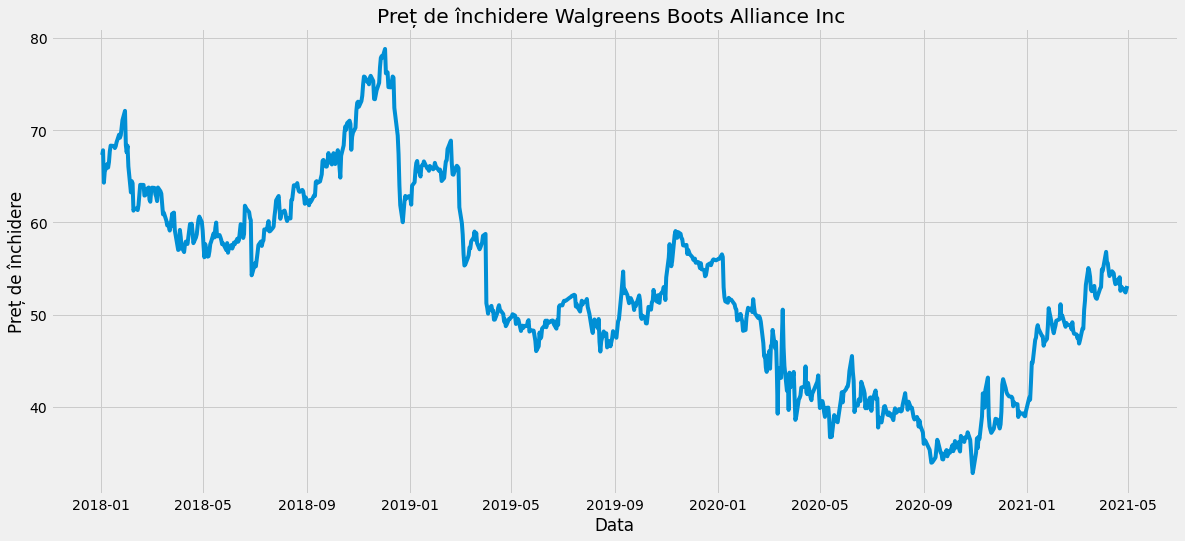

In [4]:
plt.xlabel('Data')
plt.ylabel('Preț de închidere')
plt.plot(dataset['Adj Close'])
plt.title('Preț de închidere Walgreens Boots Alliance Inc ')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

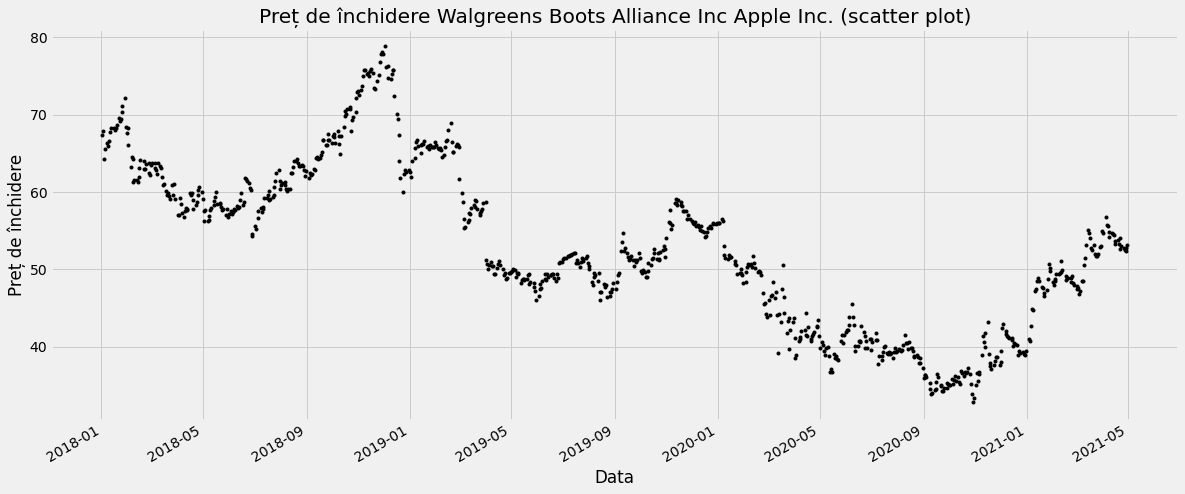

In [5]:
df_close = dataset['Adj Close']
df_close.plot(style='k.')
plt.xlabel('Data')
plt.ylabel('Preț de închidere')
plt.title('Preț de închidere Walgreens Boots Alliance Inc Apple Inc. (scatter plot)')
plt.show

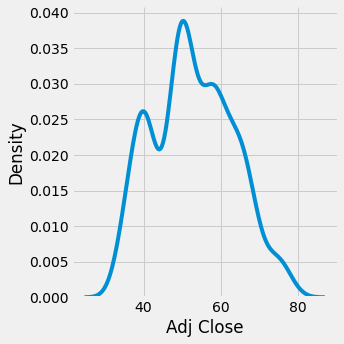

In [6]:
density = sns.displot(dataset, x="Adj Close", kind="kde")

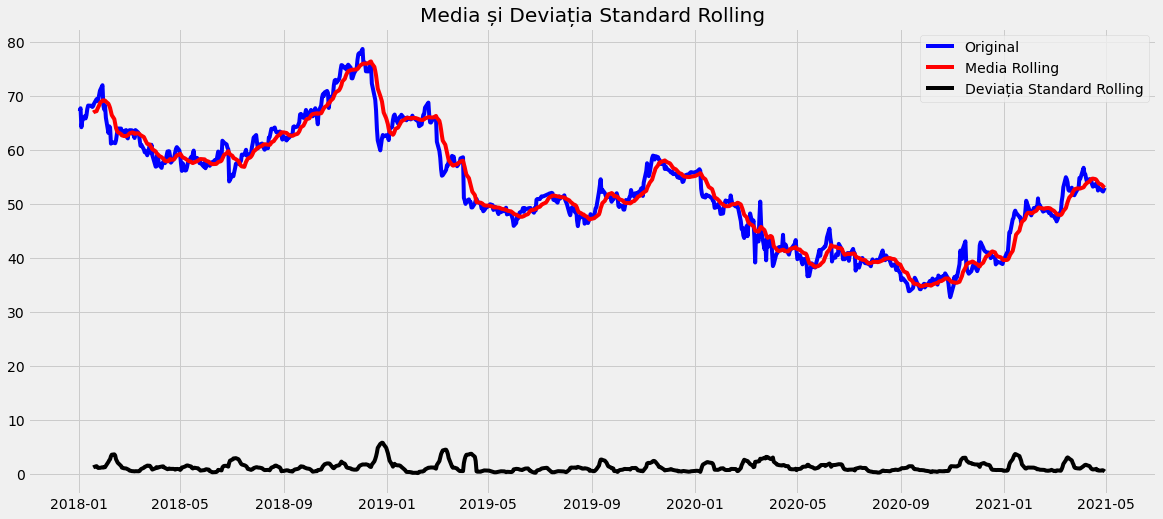

Rezultatele testului Dickey-Fuller Augmentat: 
Test statistic            -1.719743
p-value                    0.420970
Nr. decalaje folosite     13.000000
Nr. observatii           824.000000
valoare critica (1%)      -3.438311
valoare critica (5%)      -2.865054
valoare critica (10%)     -2.568641
dtype: float64


In [7]:
def test_stationarity(timeseries):
    rolling_mean = timeseries.rolling(12).mean()
    rolling_std = timeseries.rolling(12).std()
    plt.plot(timeseries, color = 'blue', label = 'Original')
    plt.plot(rolling_mean, color = 'red', label='Media Rolling')
    plt.plot(rolling_std, color = 'black', label = 'Deviația Standard Rolling')
    plt.legend(loc='best')
    plt.title('Media și Deviația Standard Rolling')
    plt.show(block=False)
    
    print('Rezultatele testului Dickey-Fuller Augmentat: ')
    adft = adfuller(timeseries, autolag = 'AIC')
    results = pd.Series(adft[0:4],index=['Test statistic','p-value','Nr. decalaje folosite','Nr. observatii'])
    for key, value in adft[4].items():
        results['valoare critica (%s)' %key] = value
    print(results)
test_stationarity(df_close)

<Figure size 1296x576 with 0 Axes>

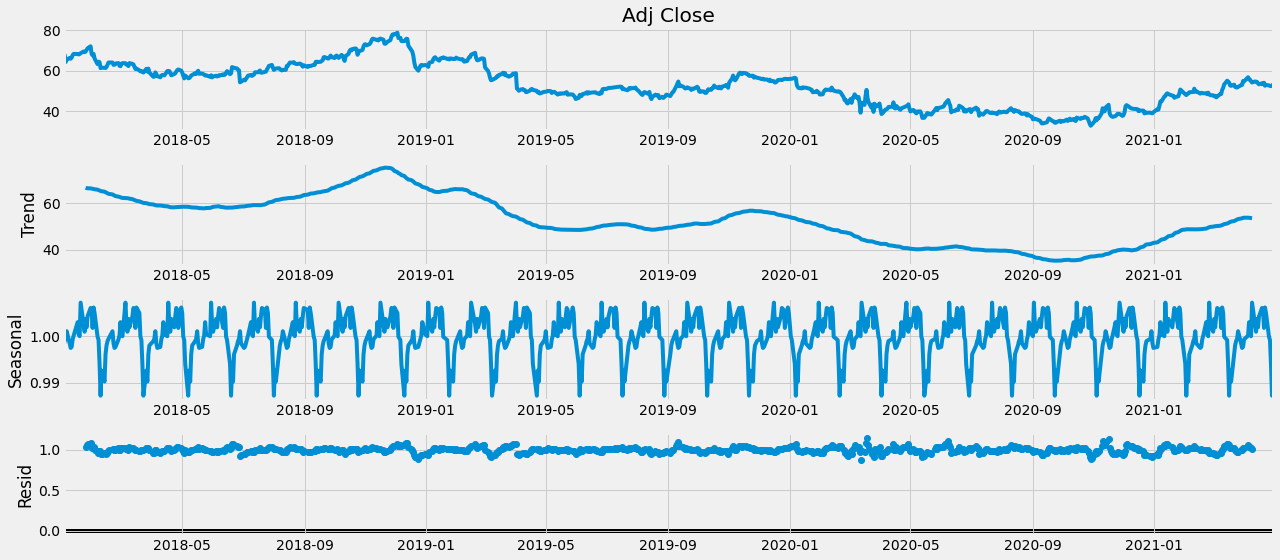

In [8]:
result = seasonal_decompose(df_close, model='multiplicative',freq = 30)
fig = plt.figure()
fig = result.plot()

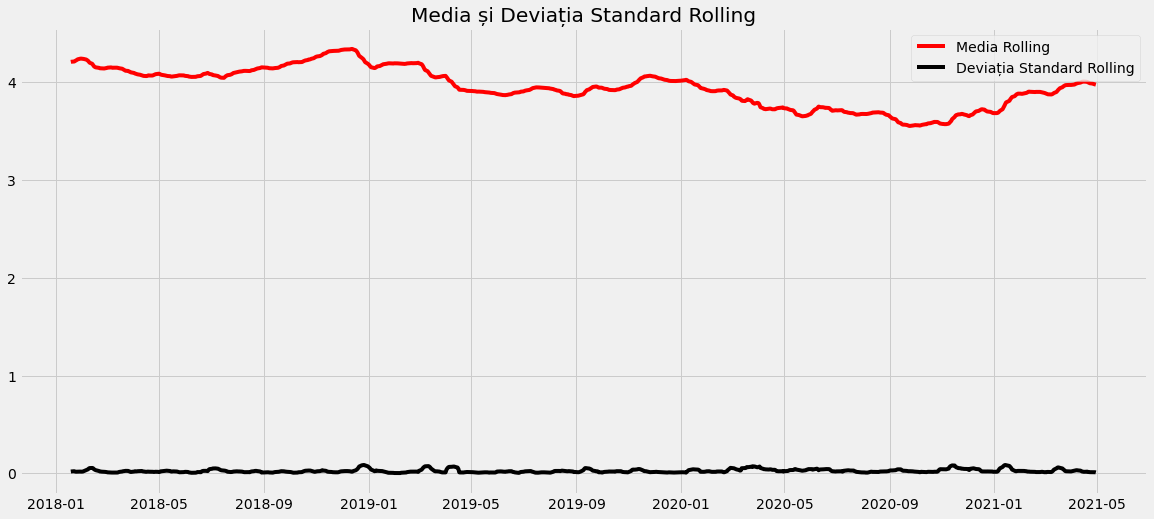

In [9]:
df_log = np.log(df_close)
rolling_mean = df_log.rolling(12).mean()
rolling_std = df_log.rolling(12).std()
plt.title('Media și Deviația Standard Rolling')
plt.plot(rolling_mean, color = 'red', label='Media Rolling')
plt.plot(rolling_std, color = 'black', label = 'Deviația Standard Rolling')
plt.legend(loc='best')
plt.show()

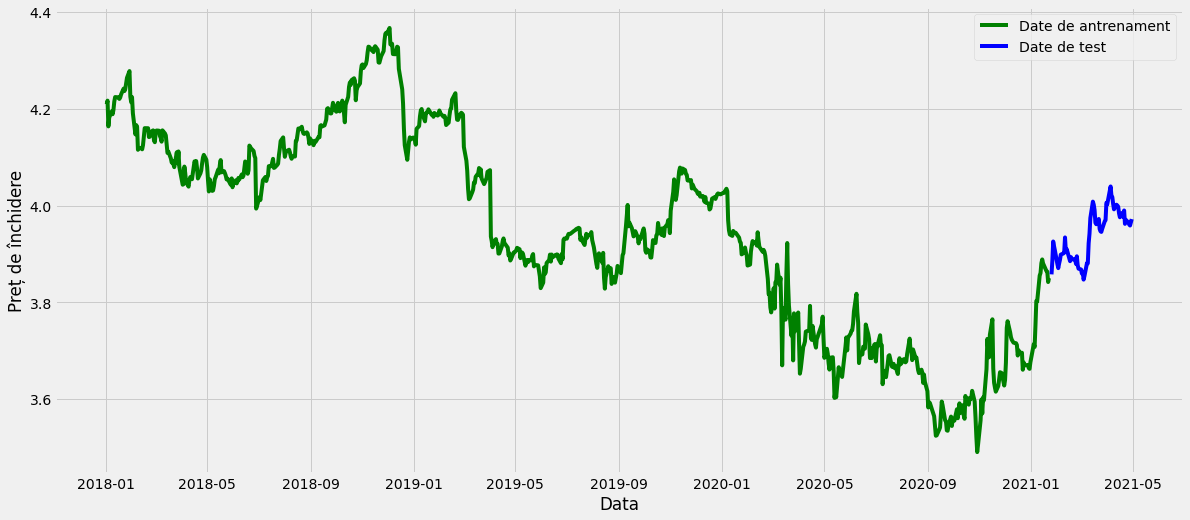

In [10]:
train_data, test_data = df_log[:int(len(df_log)*0.92)], df_log[int(len(df_log)*0.92):]
plt.xlabel('Data')
plt.ylabel('Preț de închidere')
plt.plot(train_data, 'green', label = "Date de antrenament")
plt.plot(test_data, 'blue', label = "Date de test")
plt.legend()

In [11]:
auto_ARIMA = auto_arima(train_data,
                        start_p=0, start_q=0,
                        test = 'adf',
                        max_p=4, max_q=4,
                        m=1,
                        d=None,
                        seasonal=True,
                        start_P=0, 
                        D=0,
                        trace=True,
                        error_action = 'ignore',
                        suppress_warnings=True,
                        stepwise=True,)
print(auto_ARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3632.916, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3631.251, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3631.240, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3634.592, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3629.022, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.834 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  770
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1818.296
Date:                Sun, 20 Jun 2021   AIC                          -3634.592
Time:                        15:29:04   BIC                          -3629.946
Sample:                             0   HQIC                         -3632.804
                                - 770                                  

In [13]:
first_diff = train_data - train_data.shift(1)
first_diff = first_diff.dropna(inplace = False)

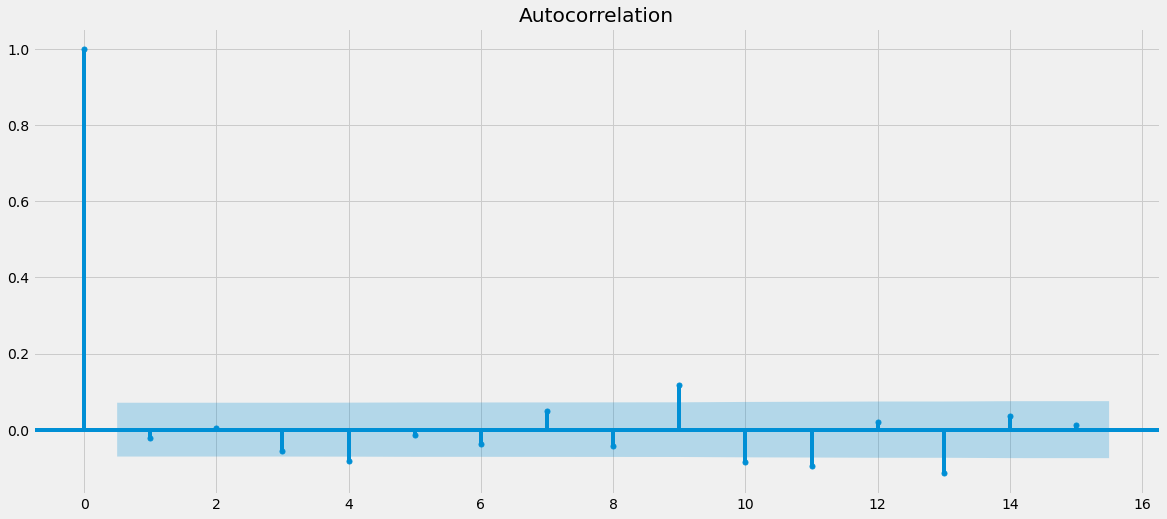

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf_plot = plot_acf(first_diff,lags = 15)

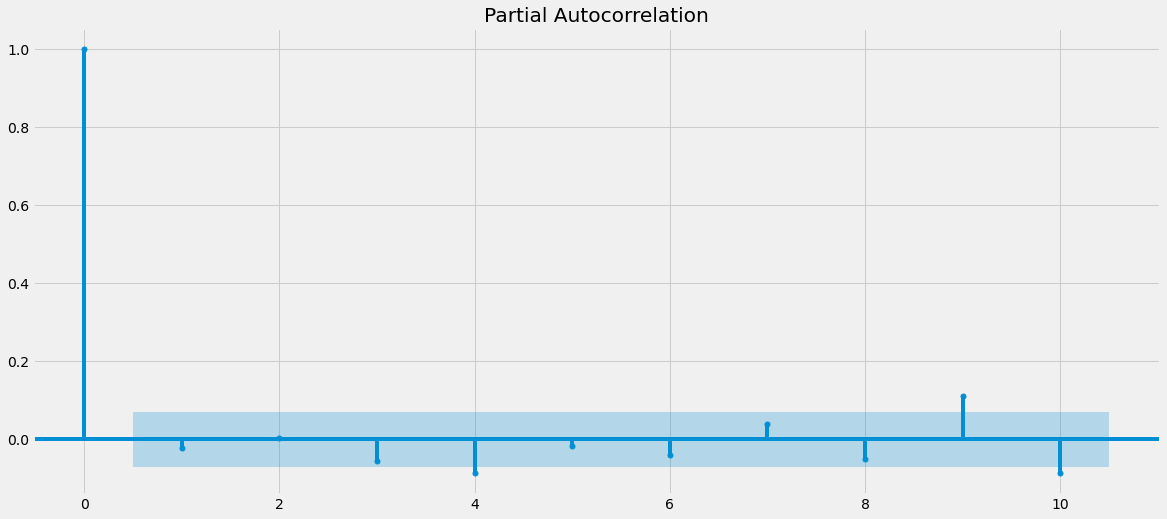

In [15]:
pacf_plot = plot_pacf(first_diff, lags=10)

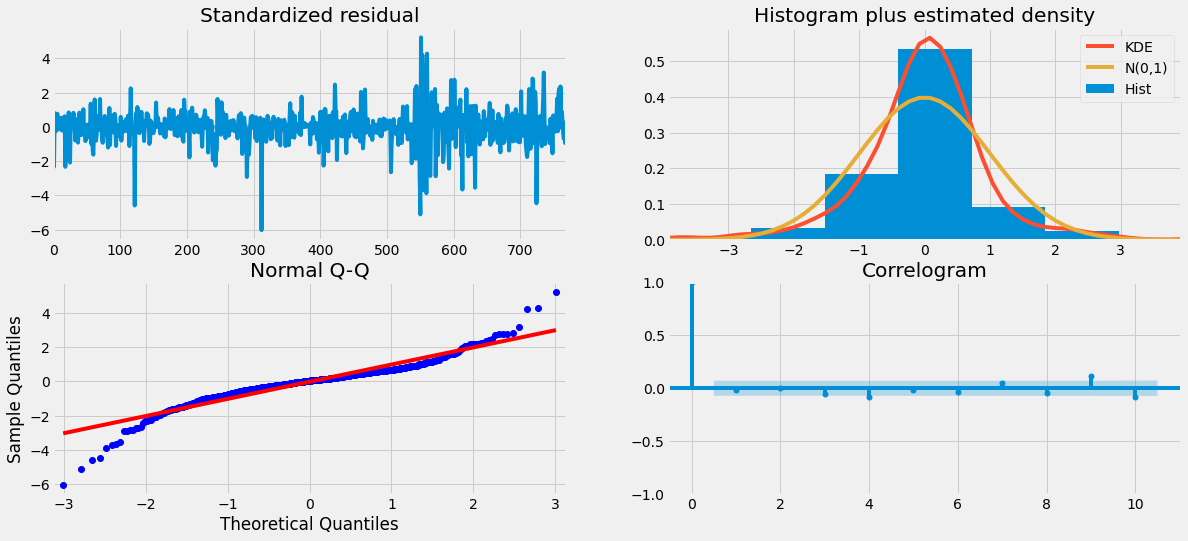

In [12]:
auto_ARIMA.plot_diagnostics()
plt.show()

In [16]:
warnings.filterwarnings('ignore')
model = ARIMA(train_data, order=(4, 1, 4))  
fitted = model.fit(disp=-1,trend = 'nc')  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                  769
Model:                 ARIMA(4, 1, 4)   Log Likelihood                1830.026
Method:                       css-mle   S.D. of innovations              0.022
Date:                Sun, 20 Jun 2021   AIC                          -3642.052
Time:                        15:29:07   BIC                          -3600.246
Sample:                             1   HQIC                         -3625.962
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ar.L1.D.Adj Close    -0.2260      0.069     -3.281      0.001      -0.361      -0.091
ar.L2.D.Adj Close     0.8140      0.096      8.461      0.000       0.625       1.003
ar.L3.D.Adj Close    -0.

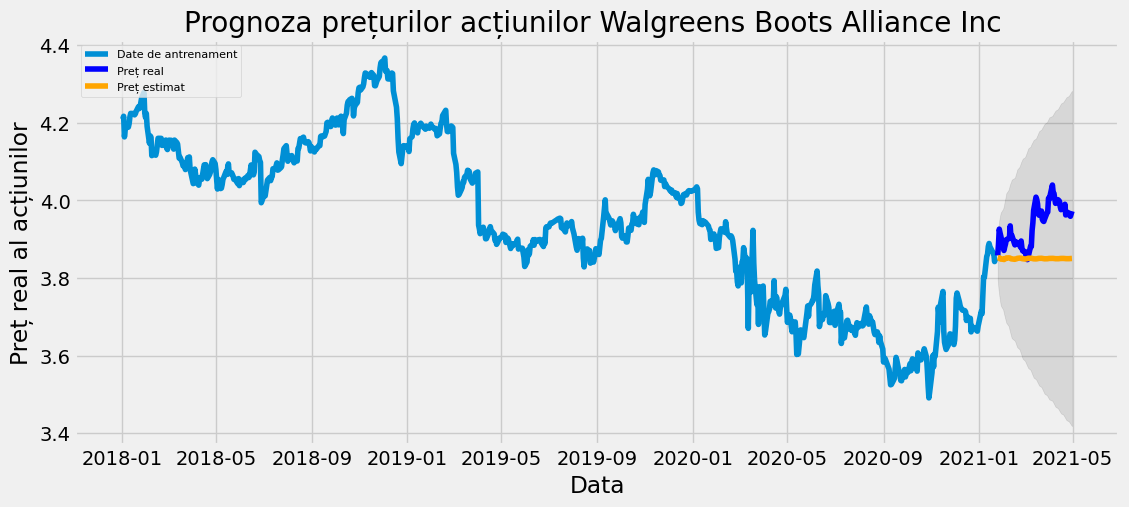

In [17]:
fc, se, conf = fitted.forecast(68, alpha=0.01)
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='Date de antrenament')
plt.plot(test_data, color = 'blue', label='Preț real')
plt.plot(fc_series, color = 'orange',label='Preț estimat')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('Prognoza prețurilor acțiunilor Walgreens Boots Alliance Inc ')
plt.xlabel('Data')
plt.ylabel('Preț real al acțiunilor')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [19]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: '+str(mse))
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))*100
print('MAPE: '+str(mape))

MSE: 25.676152017396856
MAE: 4.334234007858418
RMSE: 5.067164100105389
MAPE: 8.204515527762647
